# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
train_transforms = transforms.Compose([transforms.RandomRotation(20) , 
                                       transforms.RandomHorizontalFlip() ,
                                       transforms.ToTensor() , 
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.ToTensor() , 
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = transforms.Compose([transforms.ToTensor() , 
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Create training set and define training dataloader
train_data = torchvision.datasets.CIFAR10('CIFAR10/train' , transform = train_transforms , download = True)

trainloader = torch.utils.data.DataLoader(train_data , batch_size = 64 , shuffle = True)

#Create Validation set and define validation dataloader
validation_data = torchvision.datasets.CIFAR10('CIFAR10/test' , transform = validation_transforms , download = True)

validationloader = torch.utils.data.DataLoader(validation_data , batch_size = 64 , shuffle = True)
# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10('CIFAR10/test' , transform = test_transforms , download = True)

testloader = torch.utils.data.DataLoader(test_data , batch_size = 64 , shuffle = True)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

In [4]:
#Exploring the shapes
images , labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)
images = images.view(images.shape[0] , -1)
print(images.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])
torch.Size([64, 3072])


In [5]:
#Length of each data loader
len(trainloader) , len(testloader)

(782, 782)

In [6]:
#Just to take a glimpse on the data
images , labels = next(iter(trainloader))
print(images)
print(labels)

tensor([[[[-0.6235, -0.6471, -0.6549,  ..., -0.6157, -0.6000, -0.5843],
          [-0.6392, -0.6627, -0.6627,  ..., -0.6392, -0.6235, -0.6078],
          [-0.6471, -0.6627, -0.6706,  ..., -0.6471, -0.6314, -0.6078],
          ...,
          [-0.6392, -0.6314, -0.6314,  ..., -0.6314, -0.6314, -0.6314],
          [-0.6549, -0.6471, -0.6471,  ..., -0.6392, -0.6235, -0.6235],
          [-0.6471, -0.6471, -0.6471,  ..., -0.6392, -0.6235, -0.6235]],

         [[-0.5922, -0.5843, -0.5765,  ..., -0.5686, -0.5765, -0.5843],
          [-0.6000, -0.5922, -0.5843,  ..., -0.5765, -0.5765, -0.6000],
          [-0.6078, -0.6000, -0.5922,  ..., -0.5686, -0.5765, -0.5843],
          ...,
          [-0.6157, -0.6078, -0.6078,  ..., -0.6078, -0.6078, -0.6078],
          [-0.6314, -0.6235, -0.6235,  ..., -0.6157, -0.6000, -0.6000],
          [-0.6235, -0.6235, -0.6235,  ..., -0.6157, -0.6000, -0.6000]],

         [[-0.5373, -0.5451, -0.5529,  ..., -0.5059, -0.5059, -0.4980],
          [-0.5922, -0.5765, -

truck


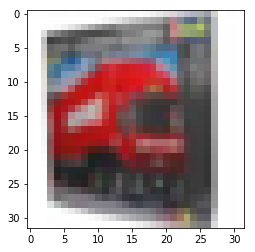

plane


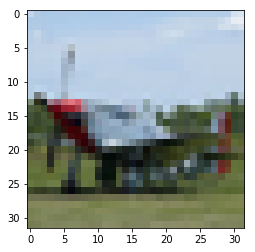

plane


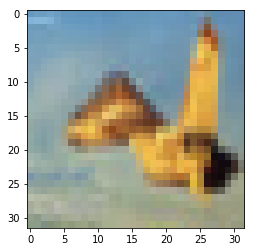

frog


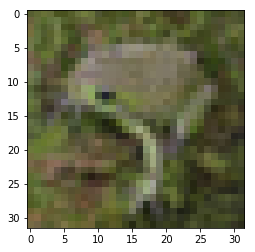

cat


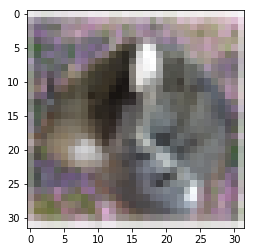

In [7]:
# printing the images
viewloader =  torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('CIFAR10/train' , transform = transforms.ToTensor()) ,
                                          batch_size = 64 ,
                                          shuffle = True)
show5(viewloader)

**NOTE**__: The view loader is just for viewing the data with just `ToTensor()` transform

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
#Following up with the convoulotional layers
cv1 = nn.Conv2d(3,9,3 , padding = 1)
cv2 = nn.Conv2d(9,27,3 , padding = 1)
cv3 = nn.Conv2d(27 ,64 ,3 , padding = 1)

pool = nn.MaxPool2d(2,2)

images , labels = next(iter(trainloader))

print('The size of the images : {}'.format(images.shape))
x = cv1(images)
x = pool(x)
print('After pooling the first convoulotional layer {}'.format(x.shape))
x = cv2(x)
x = pool(x)
print('After pooling the second convoulotional layer {}'.format(x.shape))
x = cv3(x)
x = pool(x)
print('After pooling the third convoulotional layer {}'.format(x.shape))

The size of the images : torch.Size([64, 3, 32, 32])
After pooling the first convoulotional layer torch.Size([64, 9, 16, 16])
After pooling the second convoulotional layer torch.Size([64, 27, 8, 8])
After pooling the third convoulotional layer torch.Size([64, 64, 4, 4])


**Looks like we end up with 64 x 64 * 4* 4 matrix so I'm going to reshape the first Fully connected layer to match with the convoulotional layers output**

In [9]:
#Classifier
class classifier(nn.Module):
    def __init__(self):
        super().__init__()
        #Convoulotional layers
        self.cv1 = nn.Conv2d(3,9,3 , padding = 1) #produce 16x16
        self.cv2 = nn.Conv2d(9,27,3 , padding = 1) #produce 8x8
        self.cv3 = nn.Conv2d(27 , 64 , 3 , padding =1) #produce 4x4
        
        #Fully Connected Layers
        self.fc1 = nn.Linear(64*4*4 , 512)
        self.fc2 = nn.Linear(512 , 128)
        self.fc3 = nn.Linear(128 , 10)
        
        #Dropout and Pooling 
        self.Dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self , x):
        #Pooling the convoulotional layers
        x = self.pool(F.relu(self.cv1(x)))
        x = self.pool(F.relu(self.cv2(x)))
        x = self.pool(F.relu(self.cv3(x)))
        
        #flatten the images 
        x = x.view(-1 , 64*4*4)
        
        #Forwarding the images to the fully connected layers
        x = self.Dropout(F.relu(self.fc1(x)))
        x = self.Dropout(F.relu(self.fc2(x)))
        
        #Calculating the output with a log softmax activation function
        x = F.log_softmax(self.fc3(x) , dim = 1) 
        
        return x
    

In [10]:
#Creating an instance from our classifier
model = classifier()

#Defining the loss function
criterion = nn.NLLLoss()

#Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
#Selecting which device to run our model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Number of epochs 
epochs = 25

#Moving our model to the selected device
model.to(device)

train_losses , validation_losses , validation_accuracies = [] , [] , []

#Setting our model to a train mode
model.train()

for e in range(epochs):
    steps = 0
    batch = 0
    running_loss = 0
    validation_loss = 0
    
    #******************************************Training******************************************#
    for images , labels in trainloader:
        steps += 1
        images , labels = images.to(device) , labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output , labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    #******************************************End Of Training******************************************#
        
        #Evaluating on each 250 batch
        if steps % 250 == 0:
            
            validation_loss = 0
            accuracy = 0
            
            #Setting the model to evaluation mode
            model.eval()
            
            
    #******************************************Validation Check******************************************#
            
            with torch.no_grad():
                batch += 1
                for images , labels in validationloader:

                    images , labels = images.to(device) , labels.to(device)

                    validation_output = model(images)

                    loss = criterion(validation_output , labels)

                    validation_loss += loss.item()

                    #Calculating accuracy
                    probs = torch.exp(validation_output)

                    top_ps , top_class = probs.topk(1 , dim = 1)

                    equals = top_class == labels.view(top_class.shape)

                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            accuracy_change = accuracy/len(validationloader)
            validation_accuracies.append(accuracy_change)
            
            train_loss_change = running_loss/len(trainloader)
            train_losses.append(train_loss_change)
            
            validation_loss_change = validation_loss/len(validationloader)
            validation_losses.append(validation_loss_change)
            
            print('*********************************************************************')        
            print('At epoch {}/{} on 250 batch validation no/{}'.format(e , epochs , batch))
            print('train loss is {:.4f}'.format(train_loss_change))
            print('validation loss is {:.4f}'.format(validation_loss_change))
            print('validation accuracy is {:.4f}'.format(accuracy/len(validationloader)))
            
            running_loss = 0
            
            #Setting the model back to the train mode
            model.train()
    #******************************************End Of The Validation Check******************************************#
            
print('*********************************************************************')            


*********************************************************************
At epoch 0/25 on 250 batch validation no/1
train loss is 0.5895
validation loss is 1.5878
validation accuracy is 0.3976
*********************************************************************
At epoch 0/25 on 250 batch validation no/2
train loss is 0.4931
validation loss is 1.3909
validation accuracy is 0.4912
*********************************************************************
At epoch 0/25 on 250 batch validation no/3
train loss is 0.4641
validation loss is 1.3464
validation accuracy is 0.5053
*********************************************************************
At epoch 1/25 on 250 batch validation no/1
train loss is 0.4311
validation loss is 1.2548
validation accuracy is 0.5443
*********************************************************************
At epoch 1/25 on 250 batch validation no/2
train loss is 0.4287
validation loss is 1.1920
validation accuracy is 0.5725
**************************************************

*********************************************************************
At epoch 14/25 on 250 batch validation no/3
train loss is 0.3173
validation loss is 0.7893
validation accuracy is 0.7257
*********************************************************************
At epoch 15/25 on 250 batch validation no/1
train loss is 0.3044
validation loss is 0.7463
validation accuracy is 0.7371
*********************************************************************
At epoch 15/25 on 250 batch validation no/2
train loss is 0.3126
validation loss is 0.7939
validation accuracy is 0.7274
*********************************************************************
At epoch 15/25 on 250 batch validation no/3
train loss is 0.3138
validation loss is 0.7988
validation accuracy is 0.7220
*********************************************************************
At epoch 16/25 on 250 batch validation no/1
train loss is 0.3101
validation loss is 0.7578
validation accuracy is 0.7343
*********************************************

Plot the training loss (and validation loss/accuracy, if recorded).

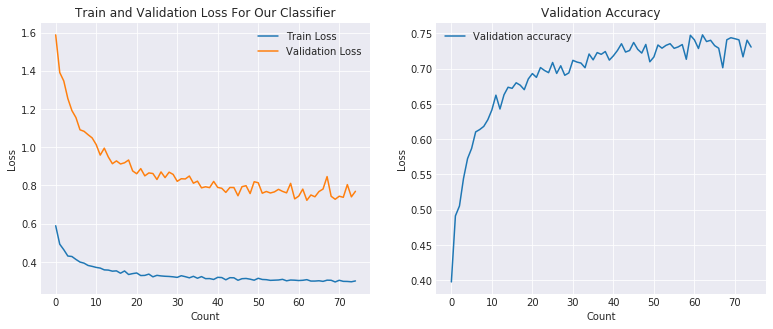

In [19]:
import seaborn as sns 
sns.set_style('darkgrid')

#Adujusting the Figure Size
plt.figure(figsize=(13,5))

#First plot
plt.subplot(1,2,1)
plt.plot(train_losses , label = 'Train Loss')
plt.plot(validation_losses , label = 'Validation Loss')
plt.xlabel('Count')
plt.ylabel('Loss')
plt.title("Train and Validation Loss For Our Classifier")
plt.legend()

#Second Plot
plt.subplot(1,2,2)
plt.plot(validation_accuracies , label = 'Validation accuracy')
plt.xlabel('Count')
plt.ylabel('Loss')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

As we look above on the two plots we see that the train loss drops from `0.6` until `0.2` and stays the same and for the validation loss we observe that it drops from `1.6` until `0.8` .

For the second plot we concluded that the validation accuracy increased from `0.39` to nearly `0.73` which is good indication that our model is performing good and our data augmentation was good .

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [18]:
#Testing our trained model on the test data (testloader)
model.eval()
test_loss = 0
test_accuracy = 0
with torch.no_grad():
                for images , labels in testloader:

                    images , labels = images.to(device) , labels.to(device)

                    test_output = model(images)

                    loss = criterion(test_output , labels)

                    test_loss += loss.item()

                    #Calculating accuracy
                    probs = torch.exp(test_output)

                    top_ps , top_class = probs.topk(1 , dim = 1)

                    equals = top_class == labels.view(top_class.shape)

                    test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()   
                    
print('Model Accuracy is {:.4f}'.format(test_accuracy/len(testloader)))
print('Model Test Loss is {:.4f}'.format(test_loss/len(testloader)))

Model Accuracy is 0.7359
Model Test Loss is 0.7638


## Saving your model
Using `torch.save`, save your model for future loading.

In [21]:
print("My Classifier: \n\n", model, '\n')

My Classifier: 

 classifier(
  (cv1): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cv2): Conv2d(9, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cv3): Conv2d(27, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (Dropout): Dropout(p=0.2)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
) 



In [22]:
torch.save(model.state_dict() , 'Classifier')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



**I would like to recommend to use the built model instead of buying a new one since the built model got 74% accuracy which is more than `Detectocorp` model .**

**My model got accuracy around 74% which is better than Detectocorp's model with 70% , my model accuracy was less than the advanced solutions , to get 74% percent accuracy first I applied three convoulotional layers to detect the features of the images and map it to the feature map for each convoulotional layer I added a relu activation to introduce non-linearity after that I applied a pooling layer to reduce the size and computation , since this dataset is a benchmark it's always good to increase the accuracy and improving models , to increase the accuracy of the model you must change to a better hyperparameters and add more layers to the features detectors (convoulotional layers).**



##### References

1- https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844

2- https://cs231n.github.io/convolutional-networks/#layers


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).